In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import sys
sys.path.append('..')

In [48]:
from autoplan.trainer import ClassifierTrainer
from autoplan.dataset import PrelabeledDataset, build_synthetic_dataset
from autoplan.generator import ProgramGenerator
from autoplan.vis import plot_accuracy, plot_cm
from autoplan.token import PyretTokenizer, OCamlTokenizer

from grammars.rainfall.ocaml import Program
from grammars.rainfall.labels import GeneralRainfallLabels

from tqdm import tqdm_notebook as tqdm
import pandas as pd
import torch
import os

# device = torch.device('cuda:0')
device = torch.device('cpu')
REPO_DIR = os.path.expanduser('~/autoplan')

In [49]:
dataset_name = 'T1'
student_dataset = PrelabeledDataset.load(f'{REPO_DIR}/data/rainfall/{dataset_name}.pkl')

In [50]:
student_dataset.dataset[0]

{'source': '#use "/course/cs017/src/ocaml/CS17setup.ml" ;;\n\n(* Prior to this course, I had relatively little programming experience. I had taken a very basic introductory course in 8th grade which focused on logo, a graphical display program, and I knew a decent amount about programming for TI calculators, but I did not take a programming class in high school. *)\n\n(* I spent about 25 minutes on this problem. *)\n\n(* I/P: a list of floats, alof *)\n(* O/P: the average of the non-negative integers in the list up to but not including the first occurence of -999. *)\n\nlet rec rainfall (alof : float list) : float = \n  let rec sum_helper (alof : float list) (sum : float) (counter : float) : (float * float) = \n    match alof, counter with\n      | [], 0. -> failwith "Empty list."\n      | -999. :: _, 0. -> failwith "Empty list."\n      | [], _ -> (sum, counter)\n      | -999. :: _, _ -> (sum, counter)\n      | hd :: tl, _ -> if hd >= 0. \n          then sum_helper tl (sum +. hd) (coun

In [62]:
df = pd.DataFrame(list(student_dataset.dataset))

In [63]:
generator = ProgramGenerator(grammar=Program())
program, choices, choice_options, labels = generator.generate()
print(program)

let  r_help 
        (rain_list : float list) (n : float) (len : float)  : float =
    
    match rain_list with
    | [] -> n /. len
    | head :: tail -> if head = -999 then n /. len
    | head :: tail -> r_help tail (head + n) (len + 1)

;;

let  rainfall (rain_list : float list) : float =
    r_help rain_list 0. 0.;;
    


In [64]:
synth_dataset = build_synthetic_dataset(
    GeneralRainfallLabels,
    N=100,
    tokenizer=OCamlTokenizer(),
    generator=ProgramGenerator(grammar=Program()),
    vocab_index=student_dataset.vocab_index)

Generating programs...


  0%|          | 0/100 [00:00<?, ?it/s]

Generated 93 unique programs.
Tokenizing programs...


100%|██████████| 100/100 [00:00<00:00, 117.95it/s]


Building dataset metadata...


In [65]:
trainer = ClassifierTrainer(synth_dataset, device)
losses = []
train_eval = []
val_eval = []

In [66]:
for _ in tqdm(range(50)):
    losses.append(trainer.train_one_epoch())
    train, val = trainer.eval()
    train_eval.append(train)
    val_eval.append(val)

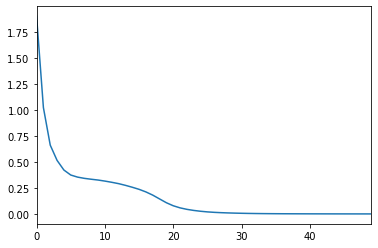

In [67]:
pd.Series(losses).plot()

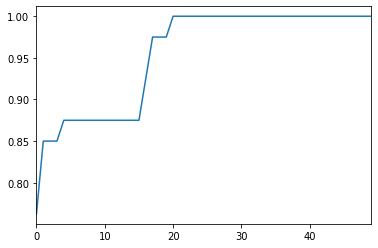

In [68]:
plot_accuracy(train_eval)

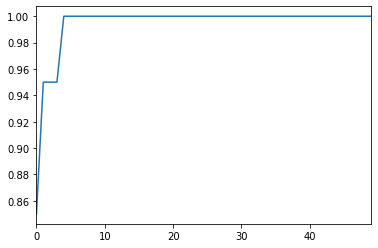

In [69]:
plot_accuracy(val_eval)

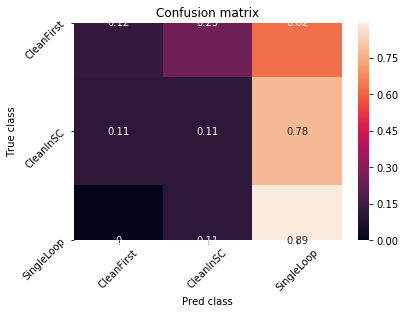

In [70]:
trainer.model.eval()
trainer.eval_on(student_dataset.loader(student_dataset.dataset)).plot_cm(normalize=True)

In [ ]:
for _, row in df[df.labels == GeneralRainfallLabels.SingleLoop].iterrows():
    print(row.source)
    print('\n{}\n'.format('='*15))